In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


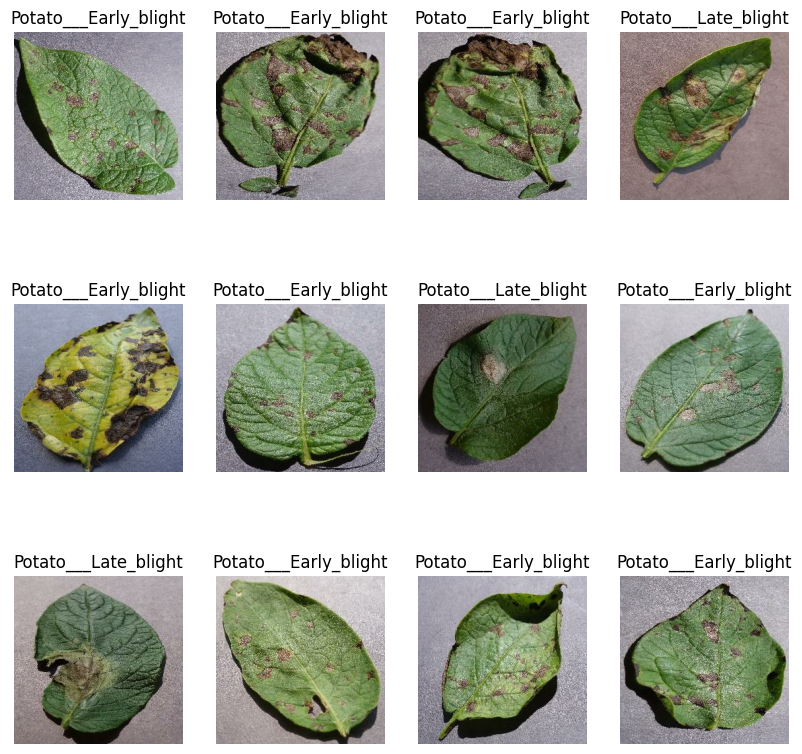

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

68

In [8]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)


14

In [11]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [12]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

54

In [16]:
len(val_ds)

6

In [17]:
len(test_ds)

8

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
from keras.layers import Resizing, Rescaling, TextVectorization, Normalization

resize_and_rescale = tf.keras.Sequential([
    Resizing(IMAGE_SIZE, IMAGE_SIZE),
    Rescaling(1./255),
])


In [20]:
from keras.layers import RandomFlip, RandomRotation
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
])

In [21]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Users\PATNALA PADMANABHAM\anaconda4\envs\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.4487 - loss: 0.9454 - val_accuracy: 0.4896 - val_loss: 0.8584
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.6419 - loss: 0.8172 - val_accuracy: 0.7604 - val_loss: 0.6376
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 54s 995ms/step - accuracy: 0.7835 - loss: 0.5324 - val_accuracy: 0.7292 - val_loss: 0.7496
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8297 - loss: 0.4070 - val_accuracy: 0.7500 - val_loss: 0.6409
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 967ms/step - accuracy: 0.8805 - loss: 0.3226 - val_accuracy: 0.8958 - val_loss: 0.2317
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 51s 936ms/step - accuracy: 0.9050 - loss: 0.2321 - val_accuracy: 0.8698 - val_loss: 0.3185
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 50s 918ms/step - accuracy: 0.9230 - loss: 0.1980 - val_accuracy: 0.9219 - val_loss: 0.2118
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 909ms/step - accuracy: 0.9261 - loss: 0.1954 - val_accuracy: 0.9

In [27]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 315ms/step - accuracy: 0.9573 - loss: 0.0902


In [28]:
scores

[0.08091464638710022, 0.96484375]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [31]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

50

In [34]:
history.history['loss'][:5]

[0.915802538394928,
 0.7519031167030334,
 0.5063481330871582,
 0.36502957344055176,
 0.28711262345314026]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

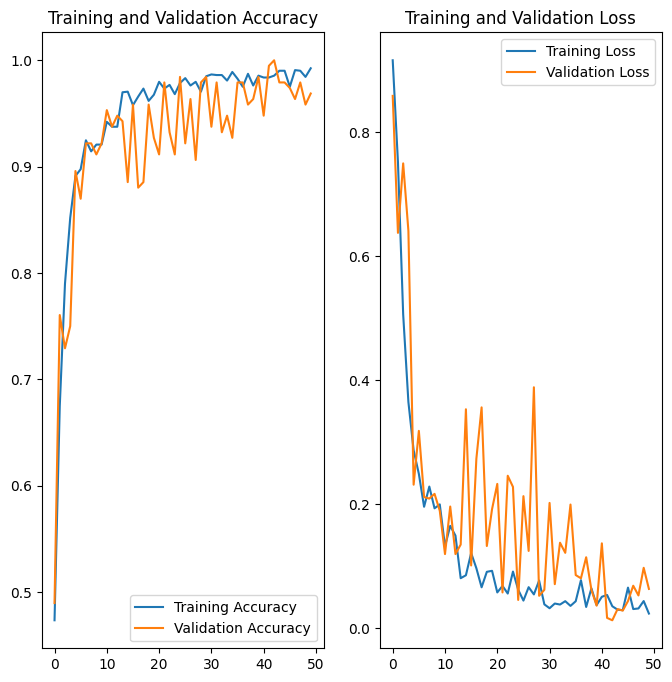

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
predicted label: Potato___Late_blight


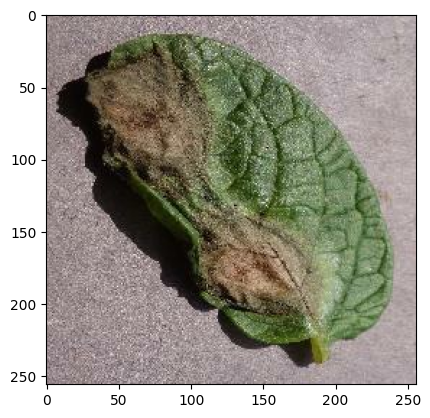

In [154]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [37]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


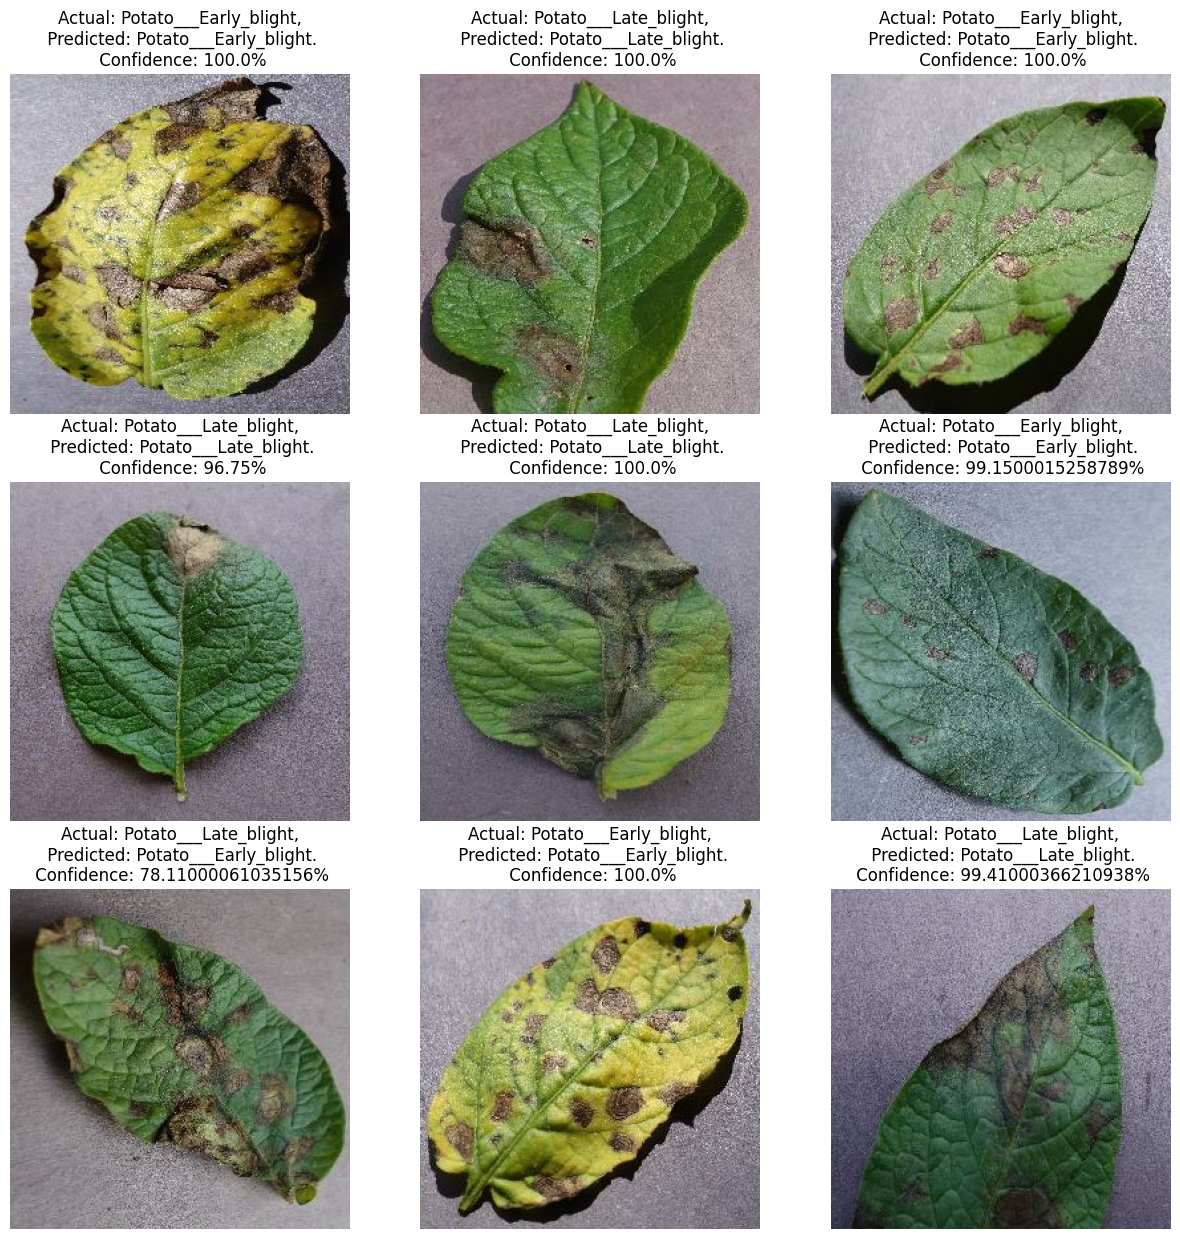

In [38]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [26]:

model_version=1
model.save(f"../models/{model_version}.keras")   


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

# PARAMETERS
IMAGE_SIZE = 256
BATCH_SIZE = 32
AUTOENCODER_MODEL_PATH = "autoencoder_256.keras"

# STEP 1: Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",  # Ensure it has only potato leaf classes
    label_mode=None,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

# STEP 2: Normalize
normalization_layer = layers.Rescaling(1./255)
dataset = dataset.map(lambda x: (normalization_layer(x), normalization_layer(x)))

# STEP 3: Functional API Autoencoder
def build_autoencoder():
    input_img = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    # Encoder
    x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(input_img)
    x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    bottleneck = layers.Dense(64, activation='relu')(x)
# Decoder (updated to stop at 256x256)
    x = layers.Dense(32 * 32 * 128, activation='relu')(bottleneck)
    x = layers.Reshape((32, 32, 128))(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)  # 32 → 64
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)   # 64 → 128
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)   # 128 → 256
    output_img = layers.Conv2DTranspose(3, 3, strides=1, padding='same', activation='sigmoid')(x)  # 256 → 256


    autoencoder = tf.keras.Model(inputs=input_img, outputs=output_img)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# STEP 4: Train the model
autoencoder = build_autoencoder()
history = autoencoder.fit(dataset, epochs=20)


Found 2152 files.
Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - loss: 0.0384
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - loss: 0.0286
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - loss: 0.0219
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - loss: 0.0202
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - loss: 0.0196
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - loss: 0.0192
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - loss: 0.0189
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - loss: 0.0184
Epoch 9/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - loss: 0.0182
Epoch 10/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - loss: 0.0181
Epoch 11/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - loss: 0.0182
Epoch 12/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - loss: 0.0178
Epoch 13/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - loss: 0.0177
Epoch 14/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - loss: 0.0173
Epoch 15/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step -

In [30]:
from PIL import Image
import numpy as np

def load_test_image(image_path, img_size=256):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((img_size, img_size))
    img = np.array(img) / 255.0  # normalize
    img = np.expand_dims(img, axis=0)  # add batch dimension
    return img
test_image = load_test_image(r"C:\Users\PATNALA PADMANABHAM\OneDrive\Desktop\potato_disease\PlantVillage\Potato___Late_blight\00b1f292-23dd-44d4-aad3-c1ffb6a6ad5a___RS_LB 4479.JPG")
  # replace with actual path

# Predict reconstruction
reconstructed = autoencoder.predict(test_image)

# Calculate reconstruction error
reconstruction_error = np.mean((test_image - reconstructed) ** 2)
print("Reconstruction Error:", reconstruction_error)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
Reconstruction Error: 0.01726111502755998


In [33]:
autoencoder.save(AUTOENCODER_MODEL_PATH)

In [34]:
import tensorflow as tf

model = tf.keras.models.load_model("autoencoder.keras")

# Convert to smaller TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

# Save the smaller model
with open("autoencoder.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\PATNAL~1\AppData\Local\Temp\tmp0d71swwa\assets


INFO:tensorflow:Assets written to: C:\Users\PATNAL~1\AppData\Local\Temp\tmp0d71swwa\assets


Saved artifact at 'C:\Users\PATNAL~1\AppData\Local\Temp\tmp0d71swwa'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)
Captures:
  2278703567216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2278703571088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2278908029488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2278908026848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2278703570384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2278908107184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2278908115456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2278908112464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2278908111936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2278908251824: TensorSpec(shape=(), dtype=tf.resource, name